In [5]:
import sys
import pandas as pd
import datetime
import os.path
from os import path
import requests
import numpy as np
import time
import pytz
# from sklearn.impute import KNNImputer
import json
from sklearn.metrics import mean_absolute_error
import calendar
import os
from dateutil.relativedelta import relativedelta
from dateutil.tz import gettz
import timeit
# from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
% matplotlib inline
address = "https://m3.meazon.com/"

In [2]:
def download_nrg(start_date, end_date, devid):
    global address

    r = requests.post(address + "api/auth/login",
                      json={'username': 'meazon@thingsboard.org', 'password': 'meazon'}).json()

    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']

    start_time = str(start_date)
    end_time = str(end_date)

    r2 = requests.get(
        url=address + "api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=pwrA,pwrB,pwrC,rpwrA,rpwrB,rpwrC&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

    if r2:
        df = pd.DataFrame([])

        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            df = pd.concat([df,df1], axis=1,sort = True)

        

        df.reset_index(drop=False, inplace=True)
        df['ts'] = pd.to_datetime(df['ts'], unit='ms')

        df = df.sort_values(by=['ts'])
        df.reset_index(drop=True, inplace=True)
        df = df.rename(columns = {"ts": "Timestamp"})
        
    else:
        df = pd.DataFrame([])
        print('Empty json!')
    

    return [df,acc_token]

In [3]:
def create_nrg_table(df,interval):
    
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
    df = df.sort_values(by="Timestamp")

    df['Timestamp'] = df['Timestamp'].astype('datetime64[s]')
    df = df.set_index('Timestamp', drop=True)
    
    
    for col in df.columns:
        df[col] = df[col].astype('float64')

    
    
    #df.index = df.index.map(lambda x: x.replace(second=0))
    ####################
    tmpdf = pd.DataFrame(df['pwrA'].dropna())
    tmpdf['minutes'] = tmpdf.index.minute
    tmpdf['interv'] = tmpdf['minutes'].shift(-1) - tmpdf['minutes']

    interv= int(tmpdf['interv'].value_counts().idxmax())
    print('interval is:',interv)
    del tmpdf
#     if interv==1: 
#         df.index = df.index.map(lambda x: x.replace(second=0))
#     else: 
#         df.index = df.index.round(str(interv) + 'T')
    df.index = df.index.map(lambda x: x.replace(second=0))
    ##########set timezone
    df['ts'] = df.index
    df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
    df.reset_index(drop=True, inplace=True)
    df.set_index('ts',inplace = True, drop = True)

    df = df.resample(interval+'T',label = 'right',closed = 'right').max()
    df.reset_index(inplace = True, drop = False)
    df.set_index('ts',inplace = True, drop = False)

    return df

In [194]:
# devid = 'af77d5e0-fc8f-11e9-ba33-b705eb64bbb5'
devid = '5db11a30-7fa1-11e8-88d7-6bb554273744' # stelios
# devid = 'be441c40-5889-11ea-8762-6bf954fc5af1' # aimilia
# start_time = '1585540800000'
# end_time = '1585654657000'
start_time = '1585540800000'
end_time = '1585654657000'

end_ = (datetime.datetime.utcnow())
start_ = end_ + relativedelta(hours=-3)

end_time = int(end_.replace(tzinfo=pytz.utc).timestamp()) * 1000
start_time = int(start_.replace(tzinfo=pytz.utc).timestamp()) * 1000

interval = '1'

[dfcnrg,acc_token] = download_nrg(start_time, end_time, devid)
energy = create_nrg_table(dfcnrg,interval)
# energy['totalact'] = energy['pwrA']+energy['pwrB']+energy['pwrC']
# energy['totalpwr'] = np.sqrt((energy['pwrA']-energy['pwrB']-energy['pwrC'])**2+(energy['rpwrA']-energy['rpwrB']-energy['rpwrC'])**2)
energy['totalpwr'] = np.sqrt((energy['pwrA'])**2+(energy['rpwrA'])**2)
# energy['totalpwr'] = np.sqrt((energy['pwrA']+energy['pwrB']+energy['pwrC'])**2+(energy['rpwrA']+energy['rpwrB']+energy['rpwrC'])**2)

energy = energy[['totalpwr']]
energy = energy.dropna()


# energy = energy.iloc[-3*2880:]
energy.head()

interval is: 3


,totalpwr
ts,
2020-04-02 12:55:00+03:00,122.297652
2020-04-02 12:58:00+03:00,122.099488
2020-04-02 13:01:00+03:00,132.909291
2020-04-02 13:04:00+03:00,132.802818
2020-04-02 13:07:00+03:00,124.853343


In [203]:
# df = energy.iloc[-2880:].copy()
df = energy.copy()
df['totalpwr'] = sp.signal.medfilt(df['totalpwr'])

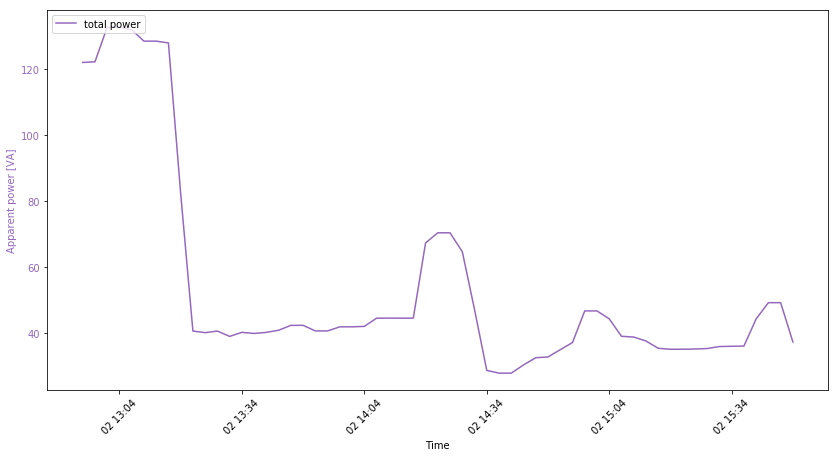

In [204]:
i=0
fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

color = 'tab:purple'
ax1.set_xlabel('Time')
ax1.set_ylabel('Apparent power [VA]', color=color)
ax1.plot(df.index, df['totalpwr'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['total power'], loc=2)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:cyan'


# ax2.set_ylabel('cluster', color=color)  # we already handled the x-label with ax1
# ax2.plot(energy.index, energy['cluster'], '-', color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend('cluster', loc=1)
# plt.title('Active power & clustering')

In [205]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def gof(x,y):
    lgof = np.sum((y-x)**2/x)
    if lgof>9.21:
        lgof=1
    else:
        lgof= 0
    return lgof

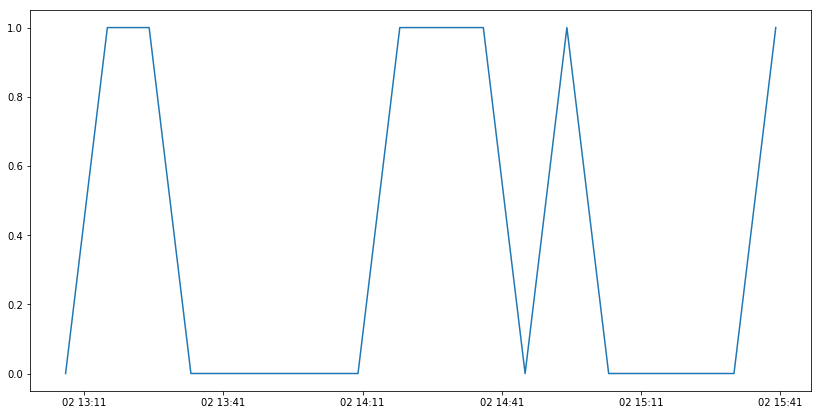

In [206]:
supervised = series_to_supervised(df, 3, 3)
supervised = supervised.iloc[1::3, :]

supervised['lgof'] = supervised.apply(lambda row : gof(row[['var1(t-3)','var1(t-2)','var1(t-1)']].values,row[['var1(t)','var1(t+1)','var1(t+2)']].values 
                                  ), axis = 1) 
fig = plt.figure(figsize=(14, 7.0))
plt.plot(supervised.index,supervised.lgof)

In [207]:
df = pd.concat([df,supervised['lgof']],axis = 1)
df = df.iloc[3:]
# df.dropna(inplace = True)
df.head()

,totalpwr,lgof
ts,,
2020-04-02 13:04:00+03:00,132.802818,NaN
2020-04-02 13:07:00+03:00,131.998268,0.0
2020-04-02 13:10:00+03:00,128.574962,NaN
2020-04-02 13:13:00+03:00,128.574962,NaN
2020-04-02 13:16:00+03:00,128.031676,1.0


In [208]:
for i in range(1,df.shape[0],3):
    if df['lgof'].iloc[i]>0:
        df['lgof'].iloc[i:i+3]=0
        
        difn = df['totalpwr'].iloc[i-1] - df['totalpwr'].iloc[i]
        dif1 = df['totalpwr'].iloc[i] - df['totalpwr'].iloc[i+1]
        dif2 = df['totalpwr'].iloc[i+1] - df['totalpwr'].iloc[i+2]
        
        if np.abs(np.abs(dif1-dif2)>10):

            maxind = np.argmax([np.abs(difn),np.abs(dif1),np.abs(dif2)])
            mx = [difn,dif1,dif2][maxind]
            
            if maxind>0:
                df['lgof'].iloc[i+maxind]=1
#                 if mx<0:
#                     df['lgof'].iloc[i+maxind+1]=1
#                 else:
#                     df['lgof'].iloc[i+maxind]=1
            else:
                df['lgof'].iloc[i]=1
        else:
            df['lgof'].iloc[i]=1
    else:
        df['lgof'].iloc[i:i+3]=0
        

In [201]:
# supper = np.ma.masked_where(df['lgof']==1, df['totalpwr'])
# slower = np.ma.masked_where(df['lgof'] ==0, df['totalpwr'])

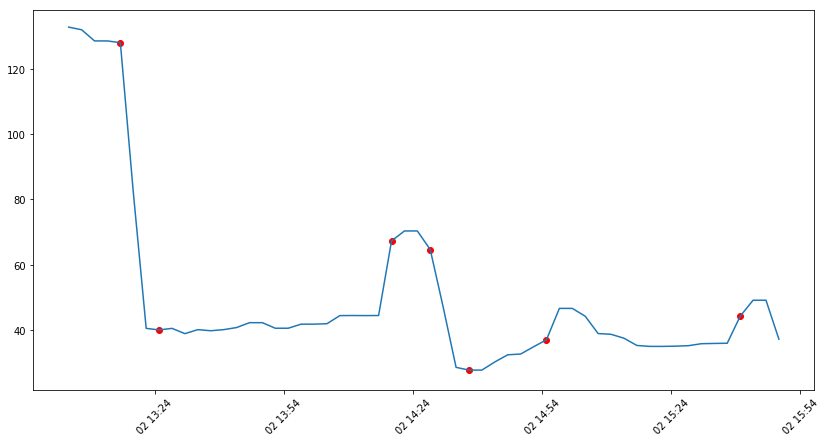

In [209]:

import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(14, 7.0))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.plot(df.index, df['totalpwr'], '-')
# Add below threshold markers
below_threshold = df['lgof']>0
plt.scatter(df.index[below_threshold], df['totalpwr'][below_threshold], color='red') 



In [210]:
df

,totalpwr,lgof
ts,,
2020-04-02 13:04:00+03:00,132.802818,NaN
2020-04-02 13:07:00+03:00,131.998268,0.0
2020-04-02 13:10:00+03:00,128.574962,0.0
2020-04-02 13:13:00+03:00,128.574962,0.0
2020-04-02 13:16:00+03:00,128.031676,1.0
2020-04-02 13:19:00+03:00,82.323178,0.0
2020-04-02 13:22:00+03:00,40.502081,0.0
2020-04-02 13:25:00+03:00,40.024352,1.0
2020-04-02 13:28:00+03:00,40.502081,0.0
